# Learning goals
After today's lesson you should be able to:
- Implement geodemographic and regionalization clustering

This week's lesson is a simplied version of:  
- The [Chapter 10 in Geographic Data Science textbook](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html)

In [1]:
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


## Data

We return to the San Diego tracts dataset we have used earlier in the book. In this case, we will not only rely on its polygon geometries, but also on its attribute information. The data comes from the American Community Survey
(ACS) from 2017. Let us begin by reading in the data.

In [2]:
# Read file
db = gpd.read_file("https://www.dropbox.com/s/g8ete3zligcozzq/sandiego_tracts.gpkg?dl=1")

To make things easier later on, let us collect the variables we will use to
characterize Census tracts. These variables capture different aspects of the 
socioeconomic reality of each area and, taken together, provide a comprehensive
characterization of San Diego as a whole. We thus create a list with the names of the columns we will use later on:

In [3]:
cluster_variables = [
    "median_house_value",  # Median house value
    "pct_white",  # % tract population that is white
    "pct_rented",  # % households that are rented
    "pct_hh_female",  # % female-led households
    "pct_bachelor",  # % tract population with a Bachelors degree
    "median_no_rooms",  # Median n. of rooms in the tract's households
    "income_gini",  # Gini index measuring tract wealth inequality
    "median_age",  # Median age of tract population
    "tt_work",  # Travel time to work
]

Let's start building up our understanding of this
dataset through both visual and statistical summaries.
The first stop is considering the spatial distribution of each variable alone.
This will help us draw a picture of the multi-faceted view of the tracts we
want to capture with our clustering. Let's use (quantile) choropleth maps for
each attribute and compare them side-by-side:

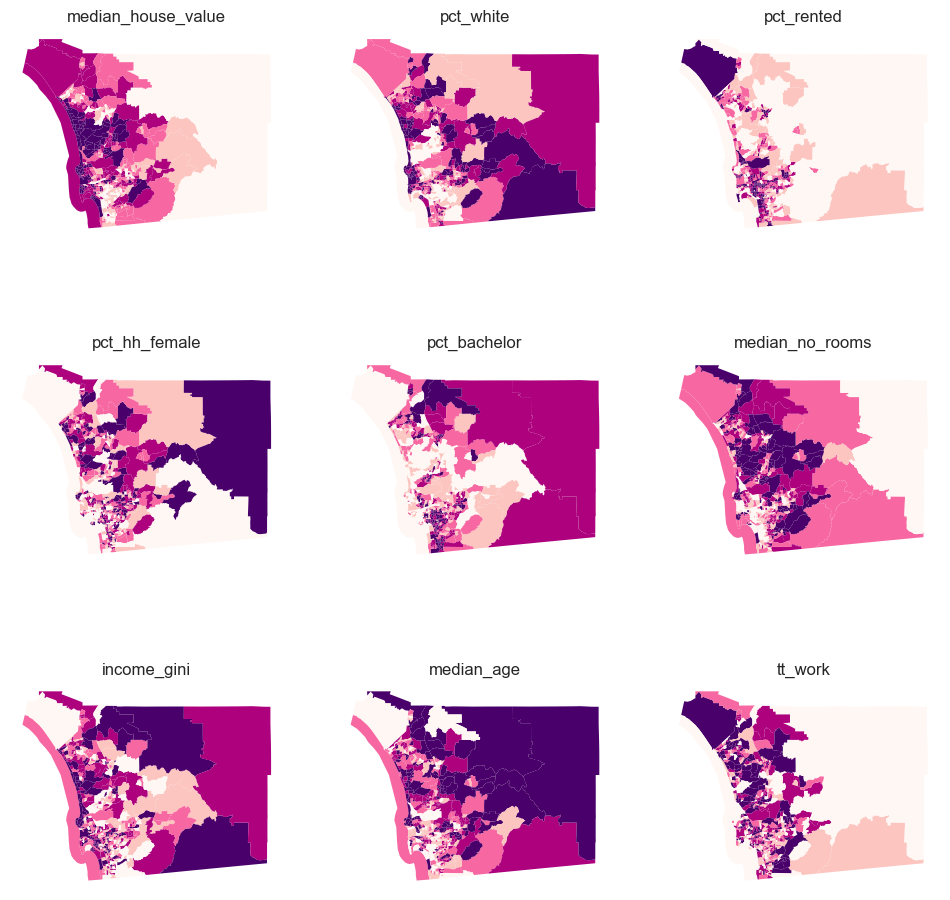

In [4]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Several visual patterns jump out from the maps, revealing both commonalities as
well as differences across the spatial distributions of the individual variables.
Several variables tend to increase in value from the east to the west
(`pct_rented`, `median_house_value`, `median_no_rooms`, and `tt_work`) while others
have a spatial trend in the opposite direction (`pct_white`, `pct_hh_female`,
`pct_bachelor`, `median_age`). This will help show the strengths of clustering;
when variables have
different spatial distributions, each variable contributes distinct 
information to the profiles of each cluster. However, if all variables display very similar 
spatial patterns, the amount of useful information across the maps is 
actually smaller than it appears, so cluster profiles may be much less useful as well.
It is also important to consider whether the variables display any
spatial autocorrelation, as this will affect the spatial structure of the
resulting clusters. 

Recall from [Chapter 6](06_spatial_autocorrelation) that Moran's I is a commonly used
measure for global spatial autocorrelation. We can use it to formalise some of the
intuitions built from the maps. Recall from earlier in the book that we will need
to represent the spatial configuration of the data points through a spatial weights
matrix. We will start with queen contiguity:

In [5]:
w = Queen.from_dataframe(db)

Now let's calculate Moran's I for the variables being used. This will measure
the extent to which each variable contains spatial structure:

In [6]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(db[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
median_house_value,0.646618,0.001
pct_white,0.602079,0.001
pct_rented,0.451372,0.001
pct_hh_female,0.282239,0.001
pct_bachelor,0.433082,0.001
median_no_rooms,0.538996,0.001
income_gini,0.295064,0.001
median_age,0.381440,0.001
tt_work,0.102748,0.001


Each of the variables displays significant positive spatial autocorrelation,
suggesting clear spatial structure in the socioeconomic geography of San
Diego. This means it is likely the clusters we find will have
a non random spatial distribution.

Spatial autocorrelation only describes relationships between observations for a
single attribute at a time.
So, the fact that all of the clustering variables are positively autocorrelated does not
say much about how attributes co-vary over space. To explore cross-attribute relationships,
we need to consider the spatial correlation between variables. We will take our first dip
in this direction exploring the bivariate correlation in the maps of covariates themselves.
This would mean that we would be comparing each pair of choropleths to look for associations
and differences. Given there are nine attributes, there are 36 pairs of maps that must be
compared. 

This would be too many maps to process visually. Instead, we focus directly
on the bivariate relationships between each pair of attributes, devoid for now of geography, and use a scatterplot matrix.

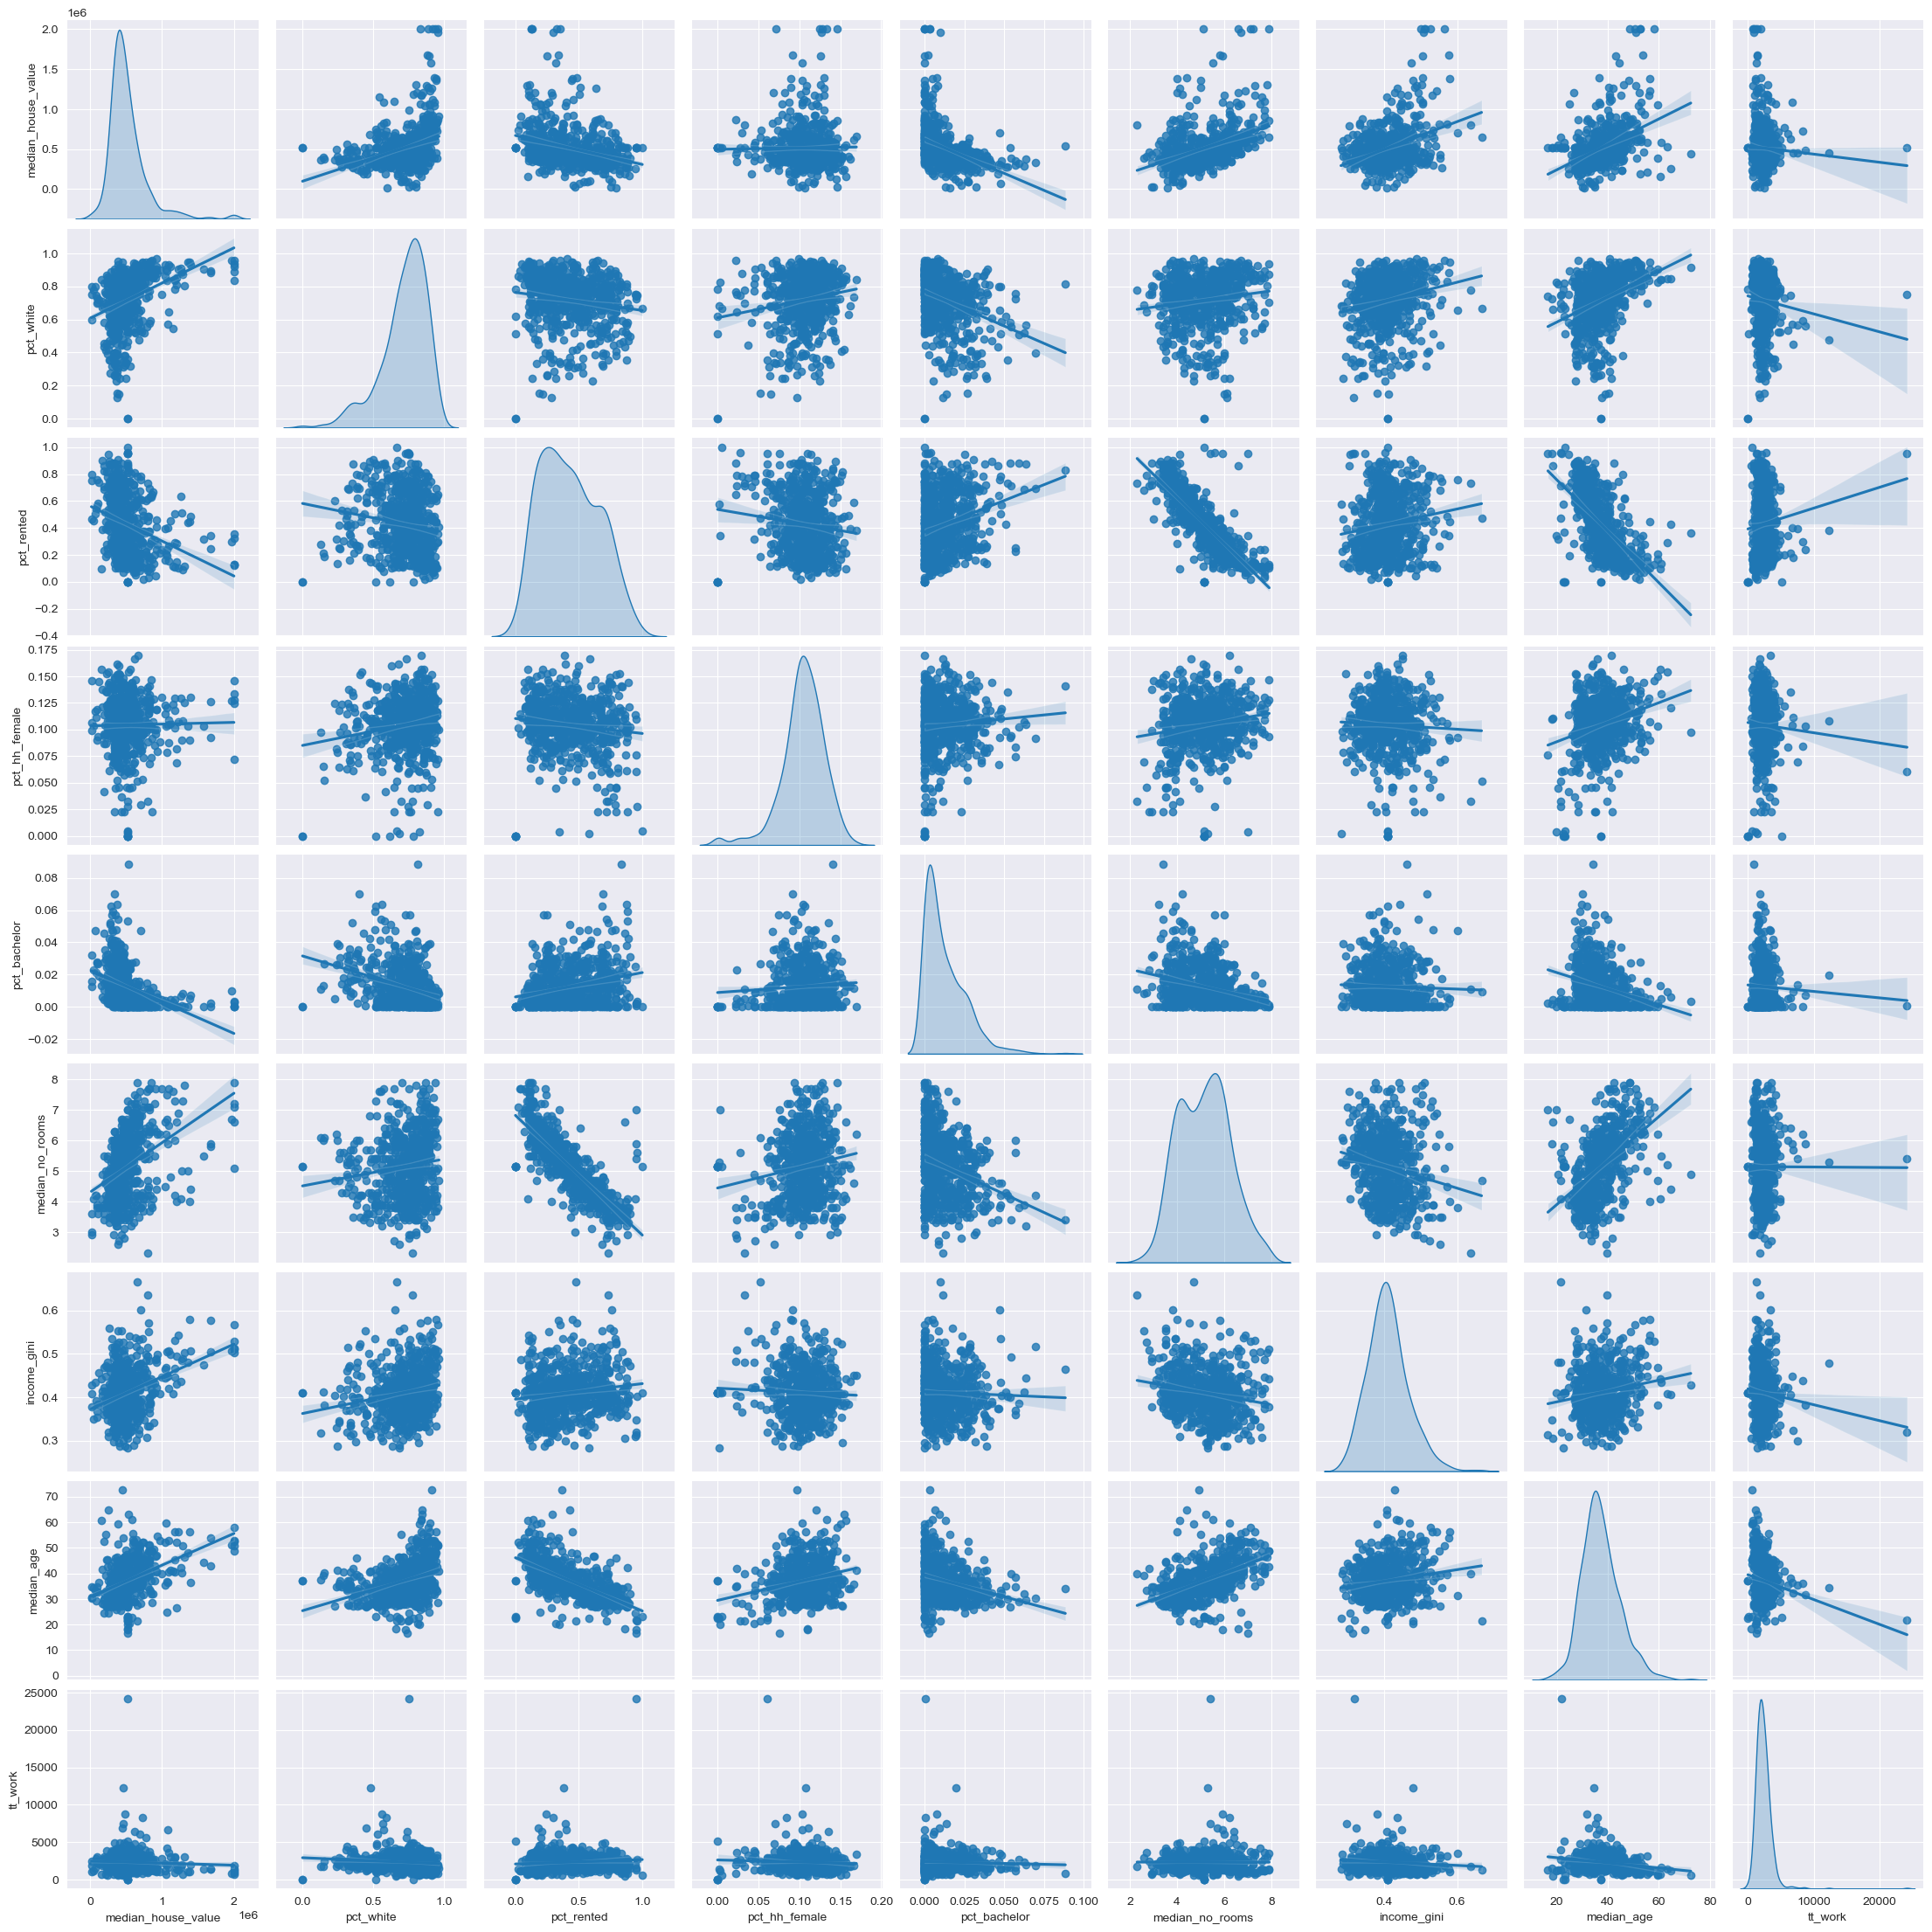

In [7]:
_ = sns.pairplot(
    db[cluster_variables], kind="reg", diag_kind="kde"
)

Two different types of plots are contained in the scatterplot matrix. On the
diagonal are the density functions for the nine attributes. These allow for an
inspection of the univariate distribution of the values for each attribute.
Examining these we see that our selection of variables includes some that are
negatively skewed (`pct_white` and `pct_hh_female`) as well as positively skewed
(`median_house_value`, `pct_bachelor`, and `tt_work`).

The second type of visualization lies in the off-diagonal cells of the matrix; 
these are bi-variate scatterplots. Each cell shows the association between one
pair of variables. **Several of these cells indicate positive linear
associations (`median_age` Vs. `median_house_value`, `median_house_value` Vs. `median_no_rooms`)
while other cells display negative correlation (`median_house_value` Vs. `pct_rented`,
`median_no_rooms` Vs. `pct_rented`, and `median_age` Vs. `pct_rented`)**. The one variable
that tends to have consistently weak association with the other variables is
`tt_work`, and in part this appears to reflect its rather concentrated 
distribution as seen on the lower right diagonal corner cell.

Indeed, this kind of concentration in values is something you need to be very aware of in clustering contexts. *Distances between datapoints* are of paramount importance in clustering applications. In fact, (dis)similarity between observations is calculated as the statistical distance between themselves. **Because distances are sensitive to the units of measurement, cluster solutions can change when you re-scale your data.**

For example, say we locate an observation based on only two variables: house price and gini coefficient. In this case:

In [8]:
db[["income_gini", "median_house_value"]].head()

,income_gini,median_house_value
0,0.5355,732900.000000
1,0.4265,473800.000000
2,0.4985,930600.000000
3,0.4003,478500.000000
4,0.3196,515570.896382


The distance between observations in terms of these variates can be computed easily using `scikit-learn`:

In [9]:
from sklearn import metrics

In [10]:
metrics.pairwise_distances(
    db[["income_gini", "median_house_value"]].head()
).round(4)

array([[     0.    , 259100.    , 197700.    , 254400.    , 217329.1036],
       [259100.    ,      0.    , 456800.    ,   4700.    ,  41770.8964],
       [197700.    , 456800.    ,      0.    , 452100.    , 415029.1036],
       [254400.    ,   4700.    , 452100.    ,      0.    ,  37070.8964],
       [217329.1036,  41770.8964, 415029.1036,  37070.8964,      0.    ]])

In this case, we know that the housing values are in the hundreds of thousands, but the Gini coefficient (which we discussed in the previous chapter) is constrained to fall between zero and one. So, for example, the distance between the first two observations is nearly totally driven by the difference in median house value (which is 259100 dollars) and ignores the difference in the Gini coefficient (which is about .11). Indeed, a change of a single dollar in median house value will correspond to *the maximum possible* difference in Gini coefficients. So, a clustering algorithm that uses this distance to determine classifications will pay a lot of attention to median house value, but very little to the Gini coefficient! 

Therefore, *as a rule*, we standardize our data when clustering. There are many different methods of standardization offered in the `sklearn.preprocessing` module, and these map onto the main methods common in applied work. We review a small subset of them here. The `scale()` method subtracts the mean and divides by the standard deviation:

$$ z = \frac{x_i - \bar{x}}{\sigma_x}$$

This "normalizes" the variate, ensuring the re-scaled variable has a mean of zero and a variance of one. However, the variable can still be quite skewed, bimodal, etc, and insofar as the mean and vairance may be affected by outliers in a given variate, the scaling can be too dramatic. One alternative intended to handle outliers better is `robust_scale()`, which uses the median and the interquartile range in the same fashion:

$$ z = \frac{x_i - \tilde{x}}{\lceil x \rceil_{75} - \lceil x \rceil_{25}}$$

where $\lceil x \rceil_p$ represents the value of the $p$th percentile of $x$. Alternatively, sometimes it is useful to ensure that the maximum of a variate is $1$ and the minimum is zero. In this instance, the `minmax_scale()` is appropriate: 

$$ z = \frac{x - min(x)}{max(x-min(x))} $$

In most clustering problems, the `robust_scale()` or `scale()` methods are useful. Further, transformations of the variate (such as log-transforming or Box-Cox transforms) can be used to nonlinearly rescale the variates, but these generally should be done before the above kinds of scaling. Here, we will analyze robust-scaled variables. To detach the scaling from the analysis, we will perform the former now, creating a scaled view of our data which we can use later for clustering. For this, we import the scaling method:

In [11]:
from sklearn.preprocessing import robust_scale

## robust_scale is a function that scales the data to have a median of 0 and a
## standard deviation of 1. This is useful for clustering algorithms that are
## sensitive to the scale of the data.

And create the `db_scaled` object which contains only the variables we are interested in, scaled:

In [12]:
db_scaled = robust_scale(db[cluster_variables])

In [13]:
db_scaled[0]

array([ 1.16897565,  0.88747229, -0.07925532, -1.85025225, -0.50838531,
       -0.7310384 ,  1.93719258,  0.1011236 , -0.6982584 ])



In conclusion, exploring the univariate and bivariate relationships is a good first step into building
a fully multivariate understanding of a dataset. To take it to the next level, we would
want to know to what extent these pair-wise relationships hold across different attributes,
and whether there are patterns in the "location" of observations within the scatter plots.
For example, do nearby dots in each scatterplot of the matrix represent the _same_ observations?
This type of questions are exactly what clustering helps us explore.

## Geodemographic Clusters in San Diego Census Tracts

Geodemographic analysis is a form of multivariate
clustering where the observations represent geographical areas {cite}`webber2018predictive`. The output
of these clusterings is nearly always mapped. Altogether, these methods use
multivariate clustering algorithms to construct a known number of
clusters ($k$), where the number of clusters is typically much smaller than the 
number of observations to be clustered. Each cluster is given a unique label,
and these labels are mapped. Using the clusters' profile and label, the map of 
labels can be interpreted to get a sense of the spatial distribution of 
socio-demographic traits. The power of (geodemographic) clustering comes
from taking statistical variation across several dimensions and compressing it
into a single categorical one that we can visualize through a map. To
demonstrate the variety of approaches in clustering, we will show two
distinct but very popular clustering algorithms: k-means and Ward's hierarchical method.

### K-means

K-means is probably the most widely used approach to
cluster a dataset. The algorithm groups observations into a
pre-specified number of clusters so that that each observation is
closer to the mean of its own cluster than it is to the mean of any other cluster.
The k-means problem is solved by iterating between an assignment step and an update step. 
First, all observations are randomly assigned one of the $k$ labels. Next, the 
multivariate mean over all covariates is calculated for each of the clusters.
Then, each observation is reassigned to the cluster with the closest mean. 
If the observation is already assigned to the cluster whose mean it is closest to,
the observation remains in that cluster. This assignment-update process continues
until no further reassignments are necessary.

The nature of this algorithm requires us to select the number of clusters we 
want to create. The right number of clusters is unknown in practice. For
illustration, we will use $k=5$ in the `KMeans` implementation from
`scikit-learn`. 

In [14]:
# Initialise KMeans instance
from sklearn.cluster import KMeans

This illustration will also be useful as virtually every algorithm in `scikit-learn`,
the (Python) standard library for machine learning, can be run in a similar fashion.
To proceed, we first create a `KMeans` clusterer object that contains the description of
all the parameters the algorithm needs (in this case, only the number of clusters):

In [15]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

Next, we set the seed for reproducibility and call the `fit` method to compute the algorithm specified in `kmeans` to our scaled data:

In [16]:
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)

Now that the clusters have been assigned, we can examine the label vector, which 
records the cluster to which each observation is assigned:

In [17]:
# Print first five labels
k5cls.labels_[:5]

array([2, 1, 3, 1, 4], dtype=int32)

In this case, the first observation is assigned to cluster 2, the second and fourth ones are assigned to cluster 1, the third to number 3 and the fifth receives the label 4. It is important
to note that the integer labels should be viewed as denoting membership only &mdash;
the numerical differences between the values for the labels are meaningless.
The profiles of the various clusters must be further explored by looking
at the values of each dimension. But, before we do that, let's make a map.

### Spatial Distribution of Clusters

Having obtained the cluster labels, we can display the spatial
distribution of the clusters by using the labels as the categories in a
choropleth map. This allows us to quickly grasp any sort of spatial pattern the 
clusters might have. Since clusters represent areas with similar
characteristics, mapping their labels allows to see to what extent similar areas tend
to have similar locations.
Thus, this gives us one map that incorporates the information from all nine covariates.

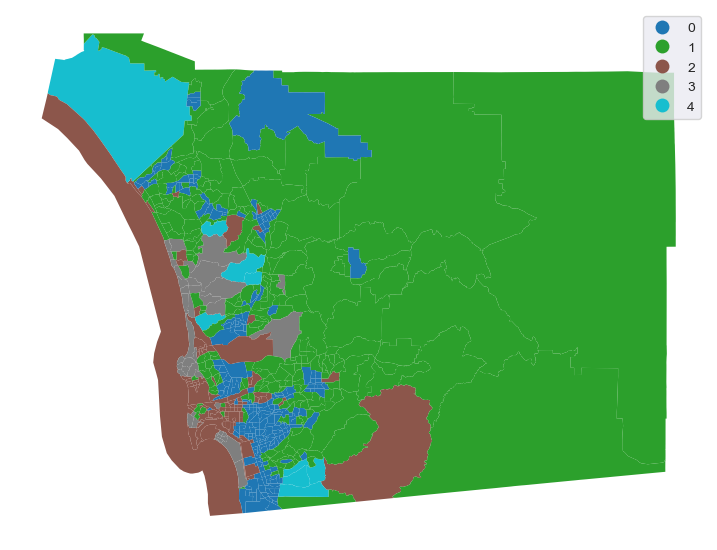

In [18]:
# Assign labels into a column
db["k5cls"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

The map provides a useful view of the clustering results; it allows for
a visual inspection of the extent to which Tobler's first law of geography is
reflected in the multivariate clusters. Recall that the law implies that nearby
tracts should be more similar to one another than tracts that are geographically
more distant from each other. We can see evidence of this in
our cluster map, since clumps of tracts with the same color emerge. However, this
visual inspection is obscured by the complexity of the underlying spatial
units. Our eyes are drawn to the larger polygons in the eastern part of the
county, giving the impression that more observations fall into that cluster. While this
seems to be true in terms of land area (and we will verify this below), there is
more to the cluster pattern than this. Because the tract polygons are all 
different sizes and shapes, we cannot solely rely on our eyes to interpret 
the spatial distribution of clusters.

### Statistical Analysis of the Cluster Map

To complement the geovisualization of the clusters, we can explore the
statistical properties of the cluster map. This process allows us to delve
into what observations are part of each cluster and what their
characteristics are.
This gives us the profile of each cluster so we can interpret the meaning of the
labels we've obtained. We can start, for example, by
considering cardinality, or the count of observations in each cluster:

In [19]:
# Group data table by cluster label and count observations
k5sizes = db.groupby("k5cls").size()
k5sizes

k5cls
0    248
1    244
2     88
3     39
4      9
dtype: int64

There are substantial differences in the sizes of the five clusters, with two very
large clusters (0,1), one medium sized cluster (2), and two small clusters (3,
4). Cluster 0 is the largest when measured by the number of assigned tracts, but cluster 1 is not far behind. This confirms our discussion from the map above, where we got the visual impression that tracts in cluster 1 seemed to have the largest area by far, but we missed exactly how large cluster 0 would be.

Let's see if this is  the case. One way to do so involves using the `dissolve` operation in `geopandas`, which 
combines all tracts belonging to each cluster into a single
polygon object. After we have dissolved all the members of the clusters,
we report the total land area of the cluster:

In [20]:
# Dissolve areas by Cluster, aggregate by summing,
# and keep column for area
areas = db.dissolve(by="k5cls", aggfunc="sum")["area_sqm"]
areas

k5cls
0     739.184478
1    8622.481814
2    1335.721492
3     315.428301
4     708.956558
Name: area_sqm, dtype: float64

We can then use cluster shares to show visually a comparison of the two membership representations (based on land and tracts):

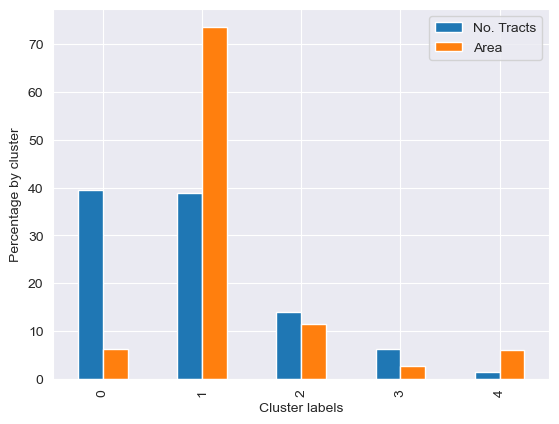

In [21]:
# Bind cluster figures in a single table
area_tracts = pd.DataFrame({"No. Tracts": k5sizes, "Area": areas})
# Convert raw values into percentages
area_tracts = area_tracts * 100 / area_tracts.sum()
# Bar plot
ax = area_tracts.plot.bar()
# Rename axes
ax.set_xlabel("Cluster labels")
ax.set_ylabel("Percentage by cluster");

Our visual impression from the map is confirmed: cluster 1 contains tracts that
together comprise 8622 square miles (about 22,330 square kilometers)
which accounts for well over half of the total land area in the county:

In [22]:
areas[1] / areas.sum()

0.7355953810798617

Let's move on to build the profiles for each cluster. Again, the profiles is what
provides the conceptual shorthand, moving from the arbitrary label to a meaningful
collection of observations with similar attributes. To build a basic profile, we can compute the (unscaled) means of each of the attributes in every cluster:

In [23]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = db.groupby("k5cls")[cluster_variables].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
median_house_value,356997.331,538463.934,544888.738,1292905.256,609385.655
pct_white,0.620,0.787,0.741,0.874,0.583
pct_rented,0.551,0.270,0.596,0.275,0.377
pct_hh_female,0.108,0.114,0.065,0.109,0.095
pct_bachelor,0.023,0.007,0.005,0.002,0.007
median_no_rooms,4.623,5.850,4.153,6.100,5.800
income_gini,0.400,0.397,0.449,0.488,0.391
median_age,32.783,42.057,32.590,46.356,33.500
tt_work,2238.883,2244.320,2349.511,1746.410,9671.556


Note in this case we do not use scaled measures. This is to create profiles that are easier to interpret and relate to. We see that cluster 3, for example, is composed of tracts that have
the highest average `median_house_value`, and also the highest level of inequality
(`income_gini`); and cluster 0 contains a younger population (`median_age`)
who tend to live in housing units with fewer rooms (`median_no_rooms`).
For interpretability, it is useful to consider the raw features, rather than scaled versions that the clusterer sees. However, you can also give profiles in terms of re-scaled features. 

Average values, however, can hide a great deal of detail and, in some cases,
give wrong impressions about the type of data distribution they represent. To
obtain more detailed profiles, we could use the `describe` command in `pandas`, 
after grouping our observations by their clusters:
```python
#-----------------------------------------------------------#
# Illustrative code only, not executed
#-----------------------------------------------------------#
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k5desc = db.groupby('k5cls')[cluster_variables].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())
#-----------------------------------------------------------#
```

However, this approach quickly gets out of hand: more detailed profiles can simply
return to an unwieldy mess of numbers. A better way of constructing
cluster profiles is to draw the distributions of cluster members' data.
To do this we need to "tidy up" the dataset. A tidy dataset {cite}`wickham2014tidy`
is one where every row is an observation, and every column is a variable. This is akin to the long-format refered to in [Chapter 9](09_spatial_inequality), and contrasts with the wide-format we used when looking at inequality over time. A few steps are required  to tidy up our labeled data:

In [24]:
# Index db on cluster ID
tidy_db = db.set_index("k5cls")
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,k5cls,Attribute,Values
0,2,median_house_value,732900.000000
1,2,pct_white,0.916988
2,2,pct_rented,0.373913
3,2,pct_hh_female,0.052896
4,2,pct_bachelor,0.000000


Now we are ready to plot. Below, we'll show the distribution of each cluster's values
for each variable. This gives us the full distributional profile of each cluster:

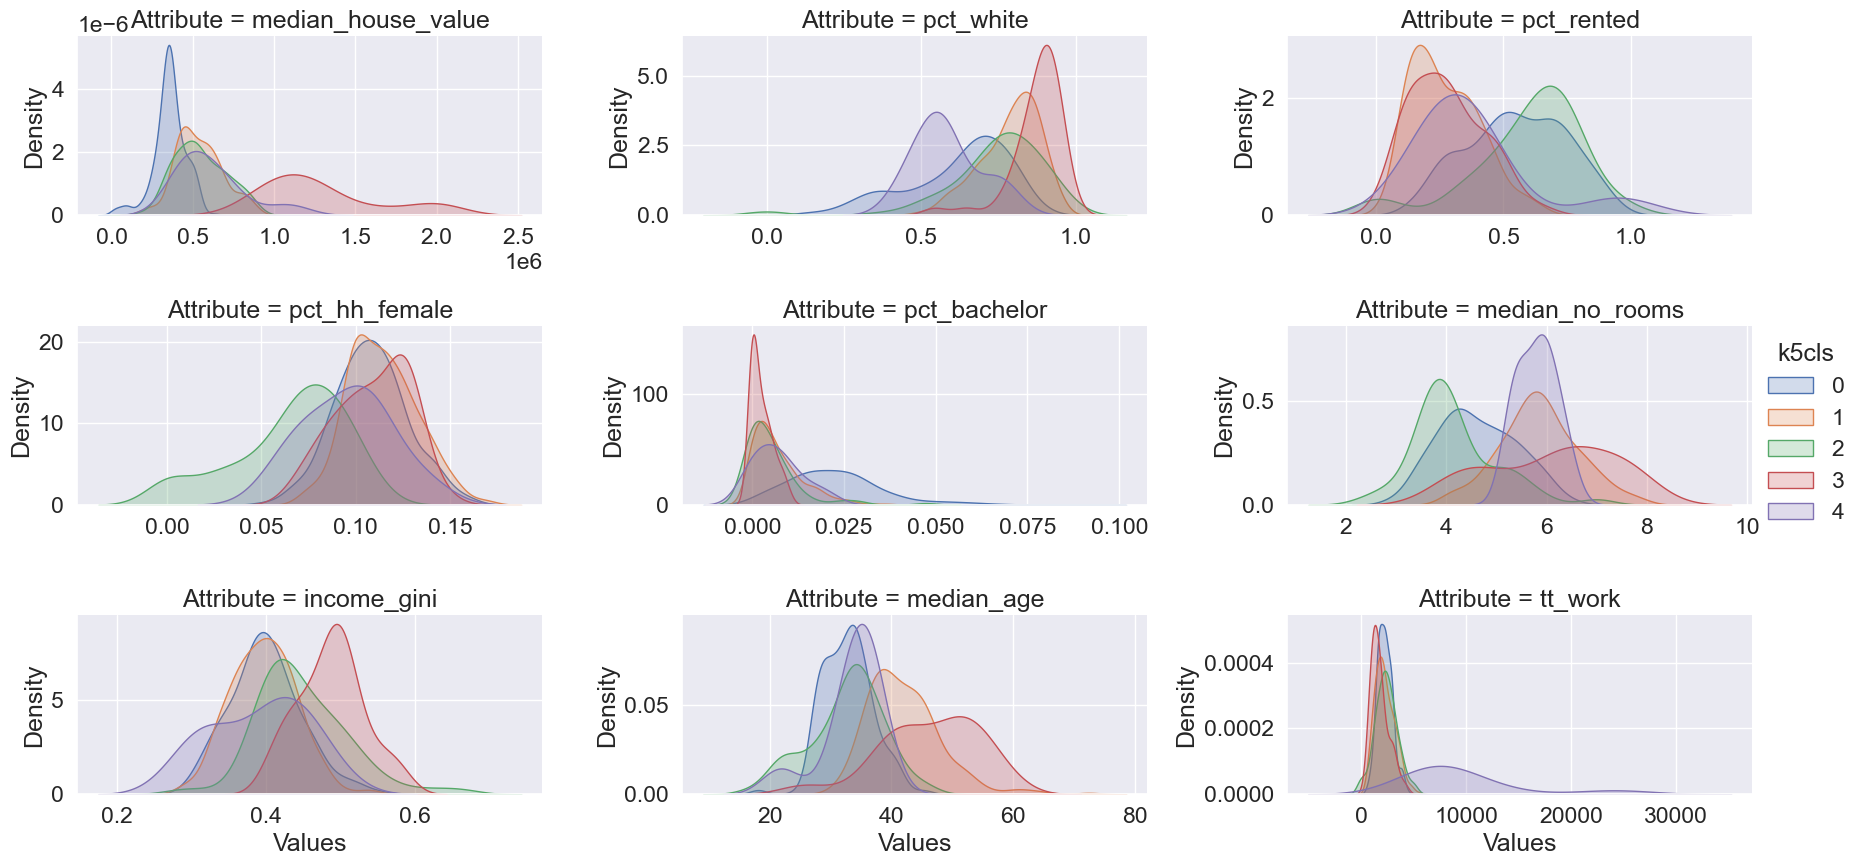

In [25]:
# Scale fonts to make them more readable
sns.set(font_scale=1.5)
# Set up the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="k5cls",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, "Values", shade=True).add_legend()

Note that we create the figure using the facetting functionality in `seaborn`, which
streamlines notably the process to create multi-plot figures whose dimensions and
content are data-driven. This happens in two steps: first, we set up the frame (`facets`),
and then we "map" a function (`seaborn.kdeplot`) to the data, within such frame.

The figure allows us to see that, while some attributes such as the percentage of
female households (`pct_hh_female`) display largely the same distribution for
each cluster, others paint a much more divided picture (e.g. `median_house_value`).
Taken altogether, these graphs allow us to start delving into the multidimensional 
complexity of each cluster and the types of areas behind them.


## Hierarchical Clustering

As mentioned above, k-means is only one clustering algorithm. There are
plenty more. In this section, we will take a similar look at the San Diego
dataset using another staple of the clustering toolkit: agglomerative
hierarchical clustering (AHC). Agglomerative clustering works by building a hierarchy of
clustering solutions that starts with all singletons (each observation is a single
cluster in itself) and ends with all observations assigned to the same cluster.
These extremes are not very useful in themselves. But, in between, the hierarchy
contains many distinct clustering solutions with varying levels of detail. 
The intuition behind the algorithm is also rather straightforward: 

1) begin with everyone as part of its own cluster; 
2) find the two closest observations based on a distance metric (e.g. euclidean); 
3) join them into a new cluster; 
4) repeat steps 2) and 3) until reaching the degree of aggregation desired. 

The algorithm is thus called "agglomerative"
because it starts with individual clusters and "agglomerates" them into fewer
and fewer clusters containing more and more observations each. Also, like with 
k-means, AHC does require the user to specify a number of clusters in advance.
This is because, following from the mechanism the method has to build clusters, 
AHC can provide a solution with as many clusters as observations ($k=n$),
or with a only one ($k=1$).

Enough of theory, let's get coding! In Python, AHC can be run
with `scikit-learn` in very much the same way we did for k-means in the previous
section. First we need to import it:

In [26]:
from sklearn.cluster import AgglomerativeClustering

In this case, we use the `AgglomerativeClustering` class and again 
use the `fit` method to actually apply the clustering algorithm to our data:

In [27]:
# Set seed for reproducibility
np.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage="ward", n_clusters=5)
# Run clustering
model.fit(db_scaled)
# Assign labels to main data table
db["ward5"] = model.labels_

As above, we can check the number of observations that fall within each cluster:

In [28]:
ward5sizes = db.groupby("ward5").size()
ward5sizes

ward5
0    198
1     10
2     48
3    287
4     85
dtype: int64

Further, we can check the simple average profiles of our clusters:

In [29]:
ward5means = db.groupby("ward5")[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
median_house_value,365932.350,625607.090,1202087.604,503608.711,503905.198
pct_white,0.589,0.598,0.871,0.770,0.766
pct_rented,0.573,0.360,0.285,0.287,0.657
pct_hh_female,0.105,0.098,0.107,0.112,0.076
pct_bachelor,0.023,0.006,0.002,0.009,0.006
median_no_rooms,4.566,5.860,6.010,5.738,3.904
income_gini,0.405,0.394,0.480,0.394,0.442
median_age,31.955,34.250,45.196,40.695,33.540
tt_work,2181.970,9260.400,1766.354,2268.718,2402.671


And again, we can tidy our dataset:

In [30]:
# Index db on cluster ID
tidy_db = db.set_index("ward5")
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,4,median_house_value,732900.000000
1,4,pct_white,0.916988
2,4,pct_rented,0.373913
3,4,pct_hh_female,0.052896
4,4,pct_bachelor,0.000000


And create a plot of the profiles' distributions:

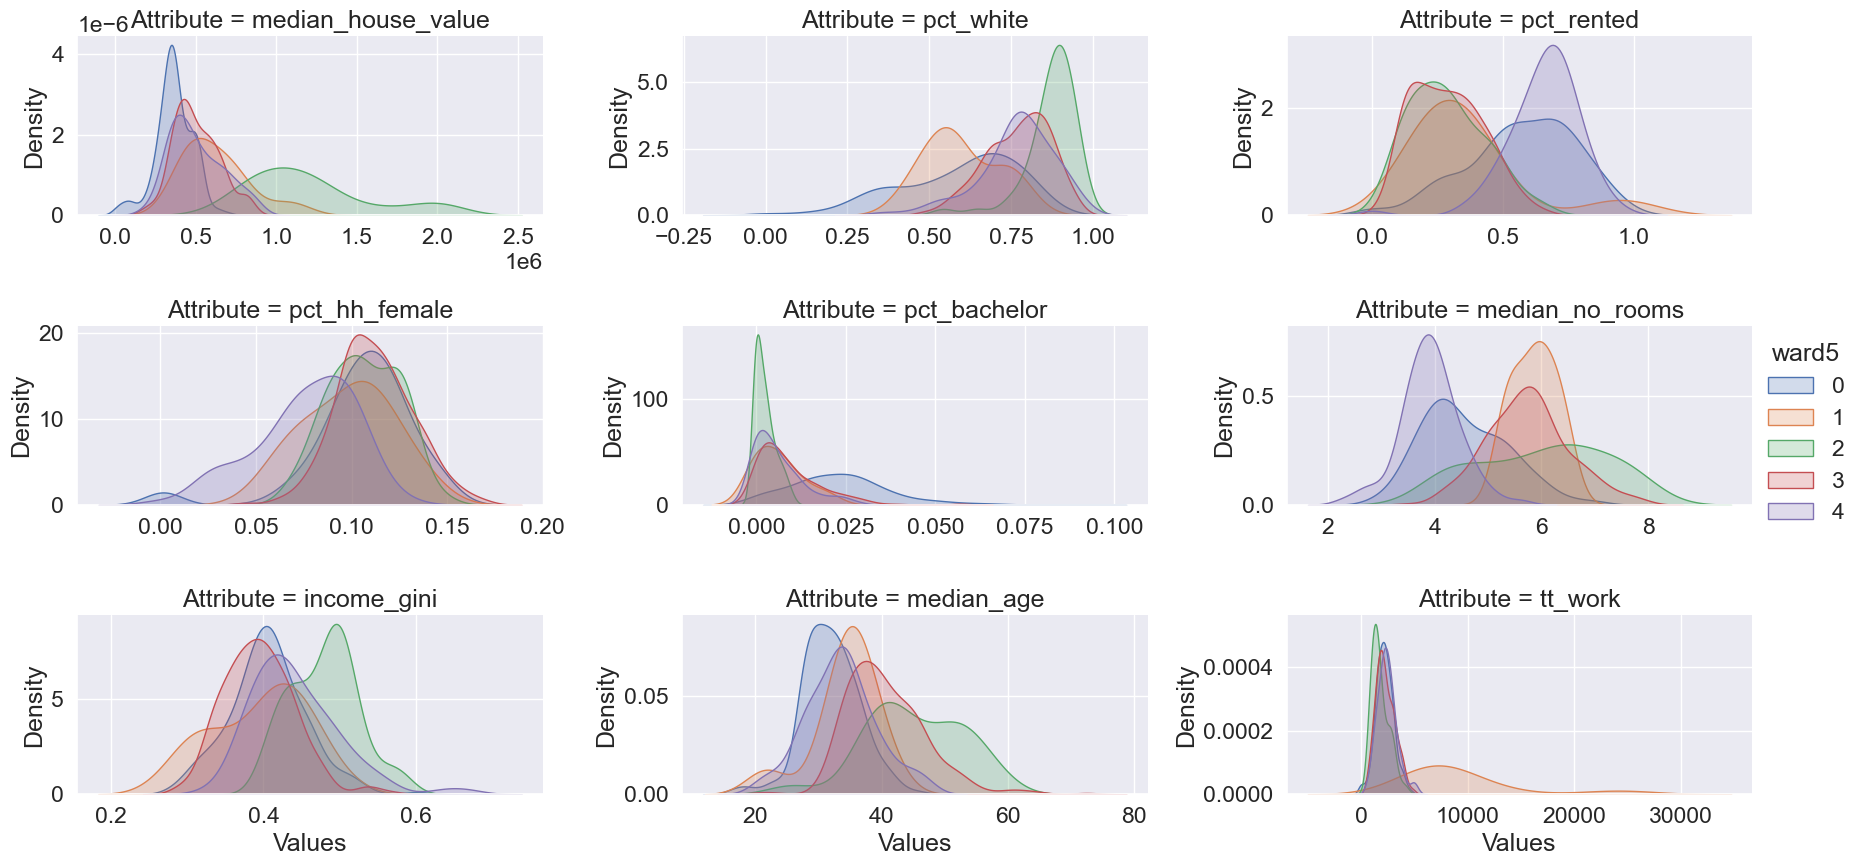

In [31]:
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="ward5",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot as a `sns.kdeplot`
facets.map(sns.kdeplot, "Values", shade=True).add_legend();

For the sake of brevity, we will not spend much time on the plots above.
However, the interpretation is analogous to that of the k-means example.

On the spatial side, we can explore the geographical dimension of the
clustering solution by making a map of the clusters. To make the comparison
with k-means simpler, we will display both side by side:

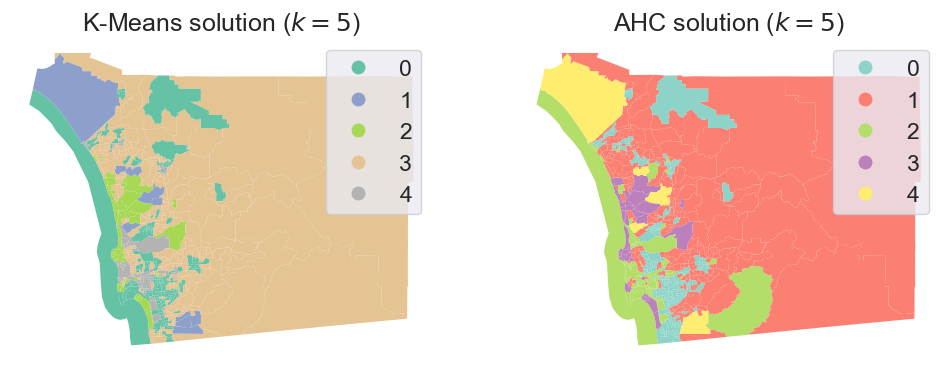

In [32]:
db["ward5"] = model.labels_
# Setup figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

### K-Means ###
ax = axs[0]
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="ward5",
    categorical=True,
    cmap="Set2",
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title("K-Means solution ($k=5$)")

### AHC ###
ax = axs[1]
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k5cls",
    categorical=True,
    cmap="Set3",
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title("AHC solution ($k=5$)")

# Display the map
plt.show()

While we must remember our earlier caveat about how irregular polygons can 
baffle our visual intuition, a closer visual inspection of the cluster geography
suggests a clear pattern: although they are not identical, both clustering solutions capture
very similar overall spatial structure. Furthermore, both solutions slightly violate 
Tobler's law in the sense all of the clusters have disconnected components. The five
multivariate clusters in each case are actually composed of many disparate 
geographical areas, strewn around the map according only to the structure of the
data and not its geography. That is, in order to travel to
every tract belonging to a cluster, we would have to journey through
other clusters as well.

## Regionalisation: Spatially Constrained Hierarchical Clustering

### Contiguity constraint

Fragmented clusters are not intrinsically invalid, particularly if we are
interested in exploring the overall structure and geography of multivariate
data. However, in some cases, the application we are interested in might
require that all the observations in a class be spatially connected. For
example, when detecting communities or neighborhoods (as is sometimes needed when
drawing electoral or census boundaries), they are nearly always distinct 
self-connected areas, unlike our clusters shown above. To ensure that clusters are
not spatially fragmented, we turn to regionalization.

Regionalization methods are clustering techniques that impose a spatial constraint
on clusters. In other words, the result of a regionalization algorithm contains clusters with
areas that are geographically coherent, in addition to having coherent data profiles. 
Effectively, this means that regionalization methods construct clusters that are 
all internally-connected; these are the *regions*. Thus, a regions' members must
be geographically *nested* within the region's boundaries.

This type of nesting relationship is easy to identify
in the real world. Census geographies provide good examples: counties nest within states
in the US; or local super output areas (LSOAs) nest within middle super output areas 
(MSOAs) in the UK. 
The difference between these real-world nestings and the output of a regionalization
algorithm is that the real-world nestings are aggregated according to administrative
principles, while regions' members are aggregated according to statistical similarity. In the same manner as the
clustering techniques explored above, these regionalization methods aggregate 
observations that are similar in their attributes; the profiles of regions are useful
in a similar manner as the profiles of clusters. But, in regionalization, the 
clustering is also spatially constrained, so the region profiles and members will
likely be different from the unconstrained solutions.

As in the non-spatial case, there are many different regionalization methods.
Each has a different way to measure (dis)similarity, how the similarity is used
to assign labels, how these labels are iteratively adjusted, and so on. However,
as with clustering algorithms, regionalization methods all share a few common traits.
In particular, they all take a set of input attributes and a representation of 
spatial connectivity in the form of a binary spatial weights matrix. Depending 
on the algorithm, they also require the desired number of output regions. For
illustration, we will take the AHC algorithm we have just used above, and apply 
an additional spatial constraint. In `scikit-learn`, this is done using
our spatial weights matrix as a `connectivity` option.
This parameter will force the agglomerative algorithm to only allow observations to be grouped
in a cluster if they are also spatially connected:

In [33]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(db_scaled)

AgglomerativeClustering(connectivity=<628x628 sparse matrix of type '<class 'numpy.float64'>'
	with 4016 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

Let's inspect the output:

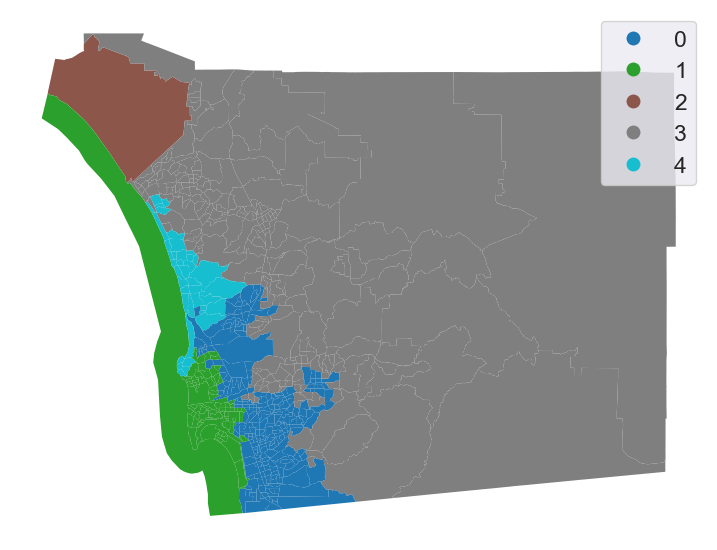

In [34]:
db["ward5wq"] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(
    column="ward5wq",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

Introducing the spatial constraint results in fully-connected clusters with much
more concentrated spatial distributions. From an initial visual impression, it might
appear that our spatial constraint has been violated: there are tracts for both cluster 0 and
cluster 1 that appear to be disconnected from the rest of their clusters.
However, closer inspection reveals that each of these tracts is indeed connected
to another tract in its own cluster by very narrow shared boundaries.

### Changing the spatial constraint

The spatial constraint in regionalization algorithms is structured by the
spatial weights matrix we use. An interesting
question is thus how the choice of weights influences the final region structure.
Fortunately, we can directly explore the impact that a change in the spatial weights matrix has on
regionalization. To do so, we use the same attribute data
but replace the Queen contiguity matrix with a spatial k-nearest neighbor matrix,
where each observation is connected to its four nearest observations, instead
of those it touches.

In [35]:
w = KNN.from_dataframe(db, k=4)

With this matrix connecting each tract to the four closest tracts, we can run 
another AHC regionalization:

In [36]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(db_scaled)

AgglomerativeClustering(connectivity=<628x628 sparse matrix of type '<class 'numpy.float64'>'
	with 2512 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

And plot the final regions:

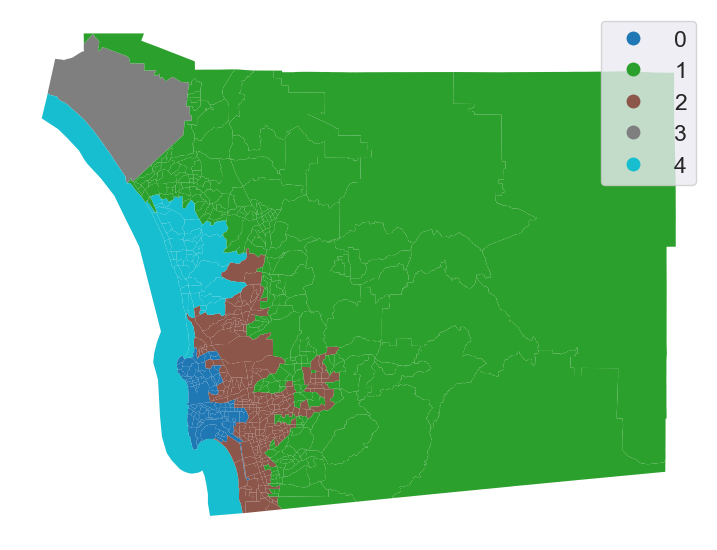

In [37]:
db["ward5wknn"] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth
# including a legend and with no boundary lines
db.plot(
    column="ward5wknn",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

Even though we have specified a spatial constraint, the constraint applies to the
connectivity graph modeled by our weights matrix. Therefore, using k-nearest neighbors
to constrain the agglomerative clustering may not result in regions that are connected
according to a different connectivity rule, such as the queen contiguity rule used
in the previous section. However, the regionalization here is fortuitous; even though
we used the 4-nearest tracts to constrain connectivity, all of our clusters are also connected according to the Queen contiguity rule. 

So, which one is a "better" regionalization? Well, regionalizations are often compared based on measures of *geographical coherence*, as well as measures of *cluster coherence*. The former involves measures of cluster *shape* that can answer to questions like "are clusters evenly-sized, or are they very differently sized? are clusters very strangely-shaped, or are they compact?";
while the latter generally focuses on whether cluster observations are more similar to their current clusters than to other clusters. This *goodness of fit* is usually better for unconstrained clustering algorithms than for the corresponding regionalizations. We'll show this next. 

### Geographical coherence

One very simple measure of geographical coherence involves the "compactness" of a given shape. The most common of these measures is the isoperimetric quotient {cite}`Horn1993`. This compares the area of the region to the area of a circle with the same perimeter as the region. To obtain the statistic, we can recognize that the circumference of the circle $c$ is the same as the perimeter of the region $i$, so $P_i = 2\pi r_c$. Then, the area of the isoperimetric circle is $A_c = \pi r_c^2 = \pi \left(\frac{P_i}{2 \pi}\right)^2$. Simplifying, we get:

$$ IPQ_i = \frac{A_i}{A_c} = \frac{4 \pi A_i}{P_i^2}$$

For this measure, more compact shapes have an IPQ closer to 1, whereas very elongated or spindly shapes will have IPQs closer to zero. For the clustering solutions, we would expect the IPQ to be very small indeed, since the perimeter of a cluster/region gets smaller the more boundaries that members share. 

Computing this, then, can be done directly from the area and perimeter of a region:

In [38]:
results = []
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # compute the region polygons using a dissolve
    regions = db[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)
# stack the series together along columns
pd.concat(results, axis=1)

,k5cls,ward5,ward5wq,ward5wknn
0,0.022799,0.018571,0.074571,0.139216
1,0.063241,0.149260,0.129419,0.245486
2,0.038124,0.046086,0.542491,0.050342
3,0.048154,0.064358,0.281874,0.542491
4,0.161781,0.027323,0.112495,0.123690


From this, we can see that the *shape* measures for the clusters are much better under the regionalizations than under the clustering solutions. As we'll show in the next section, this comes at the cost of goodness of fit. Alternatively, the two spatial solutions have different compactness values; the knn-based regions are much more compact than the queen weights-based solutions. The most compact region in the Queen regionalization is about at the median of the knn solutions. 

Many other measures of shape regularity exist. Most of the well-used ones are implemented in the `esda.shapestats` module, which also documents the sensitivity of the different measures of shape. 

### Feature coherence (goodness of fit)

Many measures of the feature coherence, or *goodness of fit*, are implemented in scikit-learn's `metrics` module, which we used earlier to compute distances. This metrics module also contains a few goodness of fit statistics that measure, for example:

- `metrics.calinski_harabasz_score()` (CH): the within-cluster variance divided by the between-cluster variance
- `metrics.silhouette_score()`: the average standardized distance from each observation to its "next best fit" cluster—the most similar cluster to which the observation is *not* currently assigned.

To compute these, each scoring function requires both the original data and the labels which have been fit. We'll compute the CH score for all the different clusterings below:

In [39]:
ch_scores = []
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
        # using scaled variables
        robust_scale(db[cluster_variables]),
        # using these labels
        db[cluster_type],
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display
pd.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
).set_index("cluster type")

,CH score
cluster type,
k5cls,115.118055
ward5,98.529245
ward5wq,62.518714
ward5wknn,54.378576


For all functions in `metrics` that end in "score", higher numbers indicate greater fit, whereas functions that end in `loss` work in the other direction. Thus, the K-means solution has the highest Calinski-Harabasz score, while the ward clustering comes second. The regionalizations both come *well* below the clusterings, too. As we said before, the improved geographical coherence comes at a pretty hefty cost in terms of feature goodness of fit. This is because regionalization is *constrained*, and mathematically *can not* achieve the same score as the unconstrained K-means solution, unless we get lucky and the k-means solution *is* a valid regionalization. 

### Solution Similarity

The `metrics` module also contains useful tools to compare whether the labellings generated from different clustering algorithms are similar, such as the Adjusted Rand Score or the Mutual Information Score. To show that, we can see how similar clusterings are to one another:

In [40]:
ami_scores = []
# for each cluster solution
for i_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # for every other clustering
    for j_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
        # compute the adjusted mutual info between the two
        ami_score = metrics.adjusted_mutual_info_score(
            db[i_cluster_type], db[j_cluster_type]
        )
        # and save the pair of cluster types with the score
        ami_scores.append((i_cluster_type, j_cluster_type, ami_score))
# arrange the results into a dataframe
results = pd.DataFrame(
    ami_scores, columns=["source", "target", "similarity"]
)
# and spread the dataframe out into a square
results.pivot("source", "target", "similarity")

target,k5cls,ward5,ward5wknn,ward5wq
source,,,,
k5cls,1.000000,0.574792,0.267554,0.302755
ward5,0.574792,1.000000,0.250029,0.258057
ward5wknn,0.267554,0.250029,1.000000,0.648272
ward5wq,0.302755,0.258057,0.648272,1.000000


From this, we can see that the K-means and Ward clusterings are the most self-similar, and the two regionalizations are slightly less similar to one another than the clusterings. The regionalizations are generally *not* very similar to the clusterings, as would be expected from our discussions above. 


## Conclusion

Overall, clustering and regionalization are two complementary tools to reduce
complexity in multivariate data and build better understandings of their spatial structure.
Often, there is simply too much data to examine every variable's map and its
relation to all other variable maps. 
Thus, clustering reduces this complexity into a single conceptual shorthand by which 
people can easily describe complex and multifaceted data. 
Clustering constructs groups of observations (called *clusters*)
with coherent *profiles*, or distinct and internally-consistent 
distributional/descriptive characteristics. 
These profiles are the conceptual shorthand, since members of each cluster should
be more similar to the cluster at large than they are to any other cluster. 
Many different clustering methods exist; they differ on how the cluster
is defined, and how "similar" members must be to clusters, or how these clusters
are obtained.
Regionalization is a special kind of clustering that imposes an additional geographic requirement. 
Observations should be grouped so that each spatial cluster,
or *region*, is spatially-coherent as well as data-coherent. 
Thus, regionalization is often concerned with connectivity in a contiguity 
graph for data collected in areas; this ensures that the regions that are identified
are fully internally-connected. 
However, since many regionalization methods are defined for an arbitrary connectivity structure,
these graphs can be constructed according to different rules as well, such as the k-nearest neighbor graph. 
Finally, while regionalizations are usually more geographically-coherent, they are also usually worse-fit to the features at hand. This reflects an intrinsic tradeoff that, in general, cannot be removed. 

In this chapter, we discussed the conceptual basis for clustering and regionalization, 
as well as showing why clustering is done. 
Further, we have demonstrated how to build clusters using a combination of (geographic) data 
science packages, and how to interrogate the meaning of these clusters as well.
More generally, clusters are often used in predictive and explanatory settings, 
in addition to being used for exploratory analysis in their own right.
Clustering and regionalization are intimately related to the analysis of spatial autocorrelation as well,
since the spatial structure and covariation in multivariate spatial data is what
determines the spatial structure and data profile of discovered clusters or regions.
Thus, clustering and regionalization are essential tools for the geographic data scientist.

## Q.1 
Describe how you might use geodemographics and regionalization in your own research or projects. Describe the research or project topic and datasets or kind of datasets.  Why might you chose one over another? (5 pts)

Geodemographics and regionalization can be useful in identifying the spatial pattern of demographic socioeconomic characteristics in a given area. For example, these methods can be used to examine the levels of vulnerability to environmental hazards like wildfire and flooding, which are often correlated with socioeconomic characteristics. However, these methods can over simplify the characteristics and impose stereotypes on the communities.
Geogemographics can provide more fine-grained categorizations of the communities, but risking the loss of information due to oversimplification. Regionalization are more useful in identifying the spatial pattern of the communities.